# Flipping-Performance

**Motviation:** The beginning of my QT was to investigate changes to the RNN so that it would be easier to calibrate it by flipping.

I switched out the $|s_{d0}|$ sort with an $s_{d0}$ sort for the tracks, and the flipping performance was slightly better for the $s_{d0}$ sort, so we decided to go with that.

One of the purposes of DIPS is to have an IP based tagger that doesn't rely on an arbitrary ordering for the tracks. However, we don't want to develop a new tagger that is *impossible* to calibrate, so I'm going to spend some time understanding how the different configurations of the LSTM and DIPS compare and perform.



In [1]:
import numpy as np
import h5py
import sys
import pandas as pd

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

sys.path.append("../../PyATLASstyle/")
from PyATLASstyle import PyATLASstyle as pas

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

In [2]:
pas.applyATLASstyle(mtp)

../../PyATLASstyle/PyATLASstyle.py


In [3]:
%%bash
nvidia-smi

Mon Mar 30 12:46:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 27%   50C    P2   134W / 250W |   8657MiB / 11178MiB |     90%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:05:00.0 Off |                  N/A |
| 26%   48C    P2   136W / 250W |   8849MiB / 12196MiB |     94%   E. Process |
+-------------------------------+----------------------+----------------------+
|   2  G

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "8"

In [4]:
tag = '_flip'

## Step 1: Load in the data for the *nominal* and *flipped* configurations

In [3]:
subDir = 'mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5'
dataDir = '../../data/' + subDir
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
# The pfn model 
dataTagTrain = "3mtrain_15trks_{}".format(vStr)
dataTagTest  = "3mtest_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
f = h5py.File(f_name,"r")

X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

jet_df = pd.read_hdf('{}/jet_3mtest_15trks_sd0_rev.h5'.format(dataDir), key='jet_df')

assert len(jet_df.index) == X.shape[0]

In [5]:
X_flip = X.copy()

X_flip[:,:,:2] *= -1
if tag == '_flip':
    X_flip = X_flip[:,::-1]


Plot the $s_{d0}$s for this configuration.

In [6]:
modelDir = '../../models/'+subDir
figDir = '../../figures/'

_, nTrks, nFeatures = X.shape

Ok - I think it would be nice to have just the normal distribution of IPs - I'm not going to bother with the flipping for the paper (for now) because I feel like I have these curves for the discriminant plots.

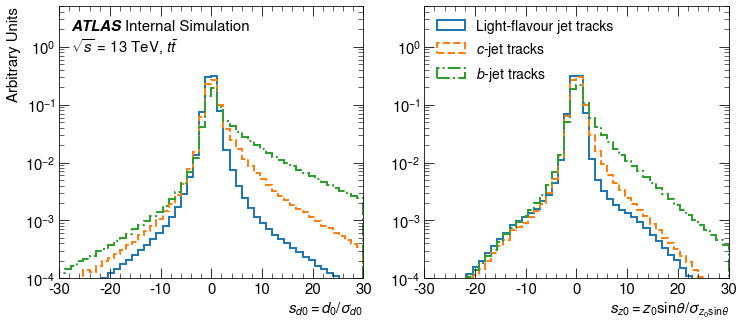

In [10]:
mask = getTrkMask(X)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

for yi,(c,f,s) in enumerate(zip(['C0','C1','C2'],['Light-flavour ','$c$-','$b$-'],['-','--','-.'])):
    ax1.hist(X[:,:,0][(y==yi).reshape(-1,1) & mask], 
             50,(-30,30),histtype='step',
             color=c,label=f+'-jet tracks',
             log=True,density=True,linewidth=2,linestyle=s)
    
    ax2.hist(X[:,:,1][(y==yi).reshape(-1,1) & mask], 
             50,(-30,30),histtype='step',
             color=c,label=f+'jet tracks',
             log=True,density=True,linewidth=2,linestyle=s)
    
ax1.set_xlabel('$s_{d0} = d_0 / \sigma_{d0}$', ha='right',x=1)
ax2.set_xlabel(r'$s_{z0} = z_0 \sin \theta / \sigma_{z_0 \sin \theta}$',ha='right',x=1)

ax1.set_ylabel('Arbitrary Units', ha='right',y=1)
ax2.legend(loc='upper left')

for ax in [ax1,ax2]:
    ax.set_xlim(-30,30)
    ax.set_ylim(1e-4,5)

pas.makeATLAStag(ax1, fig, first_tag='Internal Simulation',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, $t\bar{t}$",
                 ymax=.9)

plt.savefig('figures/sd0_sz0.pdf'.format(figDir,subDir,tag))
plt.show()

If I'm running in the negative tagger mode, I think it's good to compare the number of tracks that I have for b, c, and l-jets.

In [7]:
dense_sizes = [100] * 2
ppm_sizes = [100,100,128]

In [10]:
lstm = myLSTM(modelDir=modelDir, nFeatures=nFeatures, 
            dataTag=dataTagTrain+'_sd0_rev_iter1', 
            nHidden=100,loadModel=True,nClasses=3)

dips_bn = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
            modelDir=modelDir, dataTag=dataTagTrain+'_iter1', nClasses=3, loadModel=True, 
            dropout=0,batch_norm=True)

dips_attn = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
                 modelDir=modelDir, dataTag=dataTagTrain+'_iter4', nClasses=3, loadModel=True, 
                 dropout=0,batch_norm=True,attn=True)


Initialize method from myModel()
Loading previously trained LSTM
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/DIPS_phi_100_100_128_F_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_iter1_weights.h5
Loading previously trained DIPS weight file
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/DIPS_phi_100_100_128_F_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_iter4_weights.h5
L

## Step 2: Overlay the discriminants for each flavor for each of the configurations

In [8]:
figDir

'../../figures/'

In [14]:
subDir

'mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5'

In [8]:
rnn_colors = ['C0','C1','C2']
dips_colors = ['C0','C1','C2'] # ['C6','C9','C4']
xlabel = '$D_b = \log [ p_b / (f_c p_c + (1- f_c)p_l ) ]$'

../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_iter1.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_iter1_flip.json
Load in the previously saved efficiency file
i_eff = 62, teff = 0.846704081900308
Cut on discriminant at -0.019847669601440465
i_eff = 56, teff = 0.7761556090305621
Cut on discriminant at 1.1910592937469477
i_eff = 51, teff = 0.7011188625043598
Cut on discriminant at 2.2001484298706053
i_eff = 46, teff = 0.6092277740591386
Cut on discriminant at 3.209237565994263


../../plottingFcts.py:545: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, _ = ax1.hist(arr, range=xrange, bins=nBins, normed=normed, log=logY, **kargs)
../../plottingFcts.py:550: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot((bins[:-1]+bins[1:])/2, n/nFirst, color=kargs['color'] )
../../plottingFcts.py:550: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot((bins[:-1]+bins[1:])/2, n/nFirst, color=kargs['color'] )


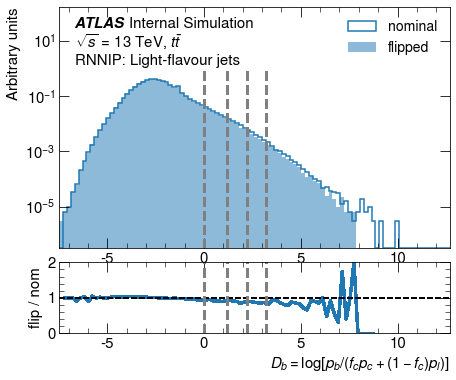

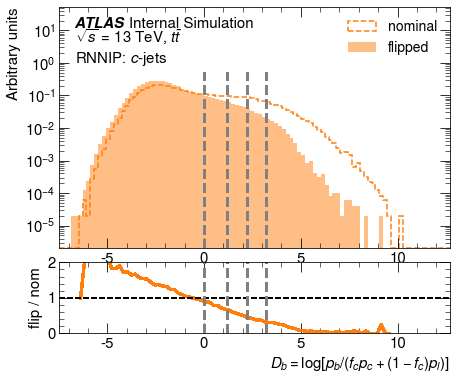

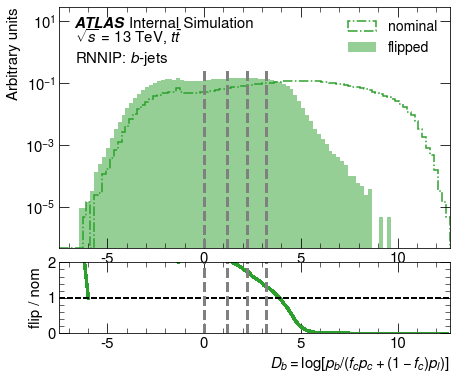

../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/effs_DIPS_phi_100_100_128_F_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_iter1.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/effs_DIPS_phi_100_100_128_F_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_iter1_flip.json
Load in the previously saved efficiency file
i_eff = 61, teff = 0.8486392856067283
Cut on discriminant at -0.024128437042236328
i_eff = 57, teff = 0.7718664903740132
Cut on discriminant at 1.268843173980713
i_eff = 54, teff = 0.7014433394310385
Cut on discriminant at 2.238571882247925
i_eff = 50, teff = 0.5887915566051942
Cut on discriminant at 3.531543493270874


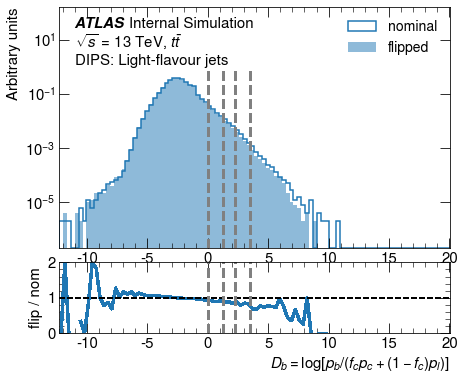

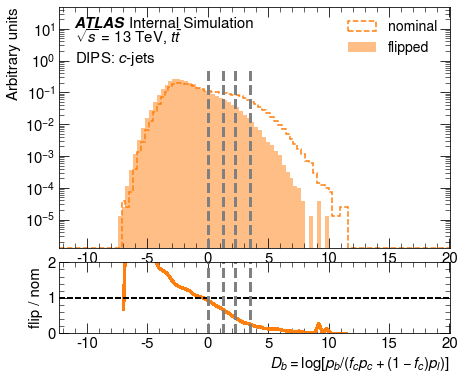

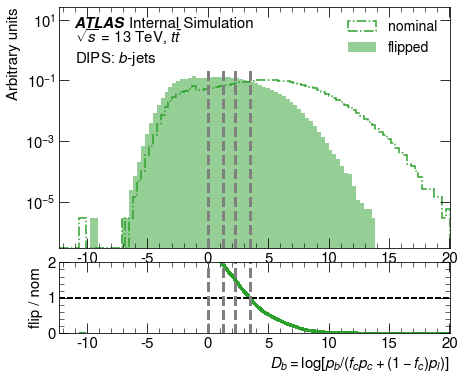

In [11]:
beffs, ceffs, leffs = [], [], []

for m, name, colors, model_tag in zip([lstm,dips_bn],['RNNIP','DIPS','DIPS+attention'],
                                   [rnn_colors,dips_colors],['rnn','dips','dips_bn_attn']):
    
    # Get the effs for the nominal configuation
    (l,c,b), d = getEffs(m, X, y, ix, returnDisc=True, figDir=figDir, subDir=subDir, modelDir=modelDir)
    
    # Get the effs for the flipped configuration
    (l_flip,c_flip,b_flip), d_flip = getEffs(m, X_flip, y, ix, returnDisc=True, figDir=figDir, 
                                             subDir=subDir, modelDir=modelDir,tag=tag)#,colors=colors)
     
    leffs += [l, l_flip]
    ceffs += [c, c_flip]
    beffs += [b, b_flip]
        
    discMax = np.max(np.concatenate((d,d_flip)))
    discMin = np.min(np.concatenate((d,d_flip)))
    myRange=(discMin,discMax) 
    nBins = 100
    
    cuts = []
    for WP in [85,77,70,60]:

        cut = workingPoint(d[y==2], nBins, myRange, WP=.01*WP)
        cuts.append(cut)
    
    for yi, flavor, c, s in zip([0,1,2], ['Light-flavour ','$c$-','$b$-'], colors,['-','--','-.']):

        hist_arr  = [d[y == yi], d_flip[y == yi]]
        kargs_arr = [{'histtype':'step','linestyle':s,'linewidth':1.5,
                      'color':c, 'label':f'nominal'}, 
                     {'alpha':0.5,  'color':c, 
                      'label':f'flipped'}]

        rlabel = 'flip / nom'
        
        dtag = flavor[:-1]+"_disc_"+model_tag+tag
        secondTag = r"$\sqrt{s}$ = 13 TeV, $t\bar{t}$"
        secondTag+=f"\n{name}: {flavor}jets"
        
        plotRatio(hist_arr, kargs_arr, 
                  xrange=myRange, nBins=nBins,rrange=(0,2),
                  xlabel=xlabel, rlabel=rlabel, title='',
                  tag=dtag, figDir=figDir, subDir=subDir, cuts=cuts,
                  secondTag=secondTag,yscale=200 if yi == 0 else 100)

    

In [16]:
pas.makeATLAStag

<function PyATLASstyle.PyATLASstyle.makeATLAStag(ax, fig, first_tag='', second_tag='', xmin=0.04, ymax=0.85)>

In [22]:
?plotRatio

In [54]:
dips.modelName

'DIPS_phi_100_100_128_F_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_iter4'

In [17]:
subDir

'mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5'

In [18]:
subDir

'mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5'

## Compare the flipped vs nominal configurations

../../plottingFcts.py:649: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


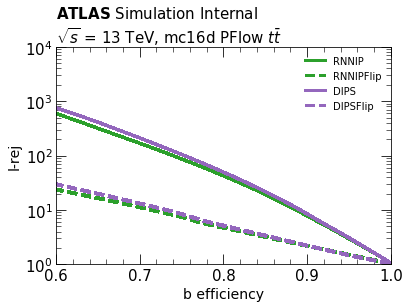

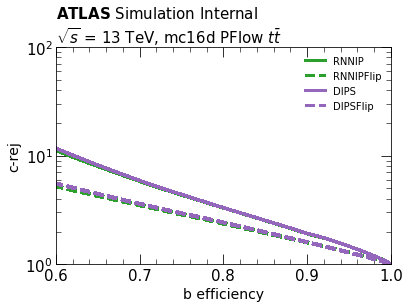

In [19]:
colors = ['C2']*2 + ['C4']*2 + ['C6']*2
styles = ['-','--']*3

labels = [f'{model}{config}' for model in ['RNNIP','DIPS','DIPSAttn'] for config in ['','Flip']]

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d PFlow $t\bar{t}$"

plotROC(beffs, leffs, labels,text=text,
        ylabel='l-rej',styles=styles,colors=colors,ymax=1e4,
        figDir=figDir,subDir=subDir,tag='lrej_newAttn'+tag)
plotROC(beffs, ceffs, labels,text=text,
        ylabel='c-rej',styles=styles,colors=colors,ymax=100,
        figDir=figDir,subDir=subDir,tag='crej_newAttn'+tag)

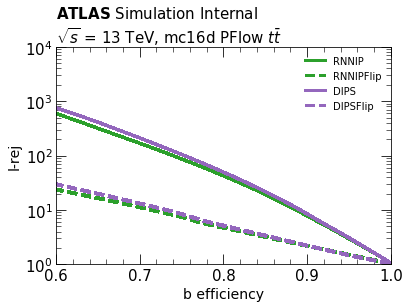

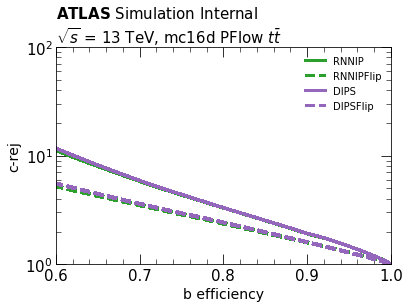

In [20]:
# colors = ['C2','C4','C6']*2
# styles = ['-']*3 + ['--']*3

colors = ['C2']*2 + ['C4']*2 + ['C6']*2
styles = ['-','--']*3

labels = [f'{model}{config}' for model in ['RNNIP','DIPS','DIPSAttn'] for config in ['','Flip']]

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d PFlow $t\bar{t}$"

plotROC(beffs, leffs, labels,text=text,
        ylabel='l-rej',styles=styles,colors=colors,ymax=1e4,
        figDir=figDir,subDir=subDir,tag='lrej_dipsFlip'+tag)
plotROC(beffs, ceffs, labels,text=text,
        ylabel='c-rej',styles=styles,colors=colors,ymax=100,
        figDir=figDir,subDir=subDir,tag='crej_dipsFlip'+tag)

**Possible plan:** I could make a roc curve with *two* subpanels?

But no matter what - to be consistent with results that I have earlier, I need to plot *all* of the iterations!!

In [21]:
tag

'_flip'

In [22]:
modelDir

'../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5'

In [23]:
figDir

'../../figures/'

In [36]:
nIter = 5

models = ['RNNIP','RNNIPFlip','DIPS','DIPSFlip']
leffs, ceffs, beffs, = {m:[] for m in models},{m:[] for m in models},{m:[] for m in models}

# Load in the evaluation data
for i in range(nIter):

    # Load in the model
    rnnip = myLSTM(modelDir=modelDir, nFeatures=nFeatures, 
                   dataTag=dataTagTrain+f'_sd0_rev_iter{i}', 
                   nHidden=100,loadModel=True,nClasses=3)
    
    leff, ceff, beff = getEffs(rnnip, X, y, ix, figDir=figDir,returnDisc=False,
                               subDir='', modelDir=modelDir, colors=['C0','C1','C2'])

    leffs['RNNIP'].append(leff)
    ceffs['RNNIP'].append(ceff)
    beffs['RNNIP'].append(beff)

    leff, ceff, beff = getEffs(rnnip, X_flip, y, ix, figDir=figDir,returnDisc=False,
                                 subDir='', modelDir=modelDir,tag=tag,
                                 colors=['C0','C1','C2'])

    leffs['RNNIPFlip'].append(leff)
    ceffs['RNNIPFlip'].append(ceff)
    beffs['RNNIPFlip'].append(beff)
    
    dips = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
                modelDir=modelDir, dataTag=dataTagTrain+f'_iter{i}', 
                batch_norm=True, nClasses=3, loadModel=True)

    leff, ceff, beff = getEffs(dips, X, y, ix, figDir=figDir,returnDisc=False,
                               subDir='', modelDir=modelDir, colors=['C6','C1','C4'])

    leffs['DIPS'].append(leff)
    ceffs['DIPS'].append(ceff)
    beffs['DIPS'].append(beff)

    leff, ceff, beff = getEffs(dips, X_flip, y, ix, figDir=figDir,returnDisc=False,
                               subDir='', modelDir=modelDir, 
                               colors=['C6','C1','C4'],tag=tag)

    leffs['DIPSFlip'].append(leff)
    ceffs['DIPSFlip'].append(ceff)
    beffs['DIPSFlip'].append(beff)


Initialize method from myModel()
Loading previously trained LSTM
../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_iter0.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_iter0_flip.json
Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/DIPS_phi_100_100_128_F_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_nor

../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/effs_DIPS_phi_100_100_128_F_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_iter4_flip.json
Load in the previously saved efficiency file


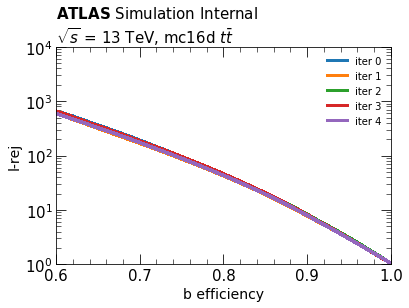

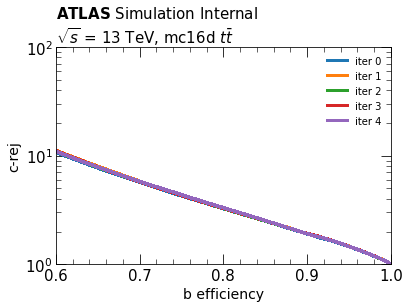

In [27]:
k = 'RNNIP'#Flip'

labels = [f'iter {i}' for i in range(5)]

plotROC(beffs[k], leffs[k], labels,#text=text,
        ylabel='l-rej',ymax=1e4,
        figDir=figDir,subDir=subDir)#,tag='lrej_newAttn'+tag)
plotROC(beffs[k], ceffs[k], labels,#text=text,
        ylabel='c-rej',ymax=100,
        figDir=figDir,subDir=subDir)#,tag='crej_newAttn'+tag)

../../plottingFcts.py:654: RuntimeWarning: divide by zero encountered in true_divide
  else:


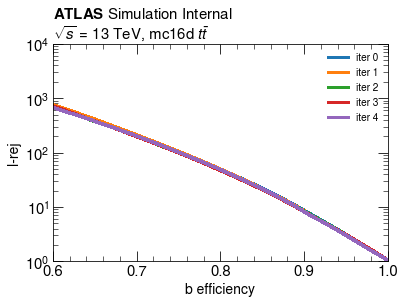

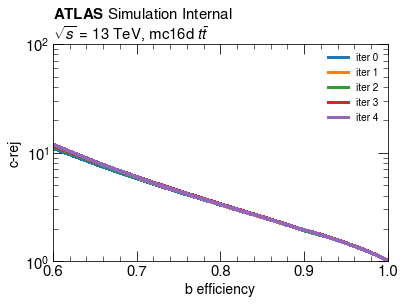

In [37]:
k = 'DIPS'#Flip'

labels = [f'iter {i}' for i in range(5)]

plotROC(beffs[k], leffs[k], labels,#text=text,
        ylabel='l-rej',ymax=1e4,
        figDir=figDir,subDir=subDir)#,tag='lrej_newAttn'+tag)
plotROC(beffs[k], ceffs[k], labels,#text=text,
        ylabel='c-rej',ymax=100,
        figDir=figDir,subDir=subDir)#,tag='crej_newAttn'+tag)

Ok, I might need a dedicated function to make this plot?

In [12]:
def flipAvgIter(teffs, beffs, labels, models=[], 
                title='',text='',
                xlabel='$b$-jet efficiency',ylabel='Background rejection',
                tag='', figDir='figures',subDir='',
                colors=['C2','C4','C6'], xmin=.6,ymax=1e3,legFontSize=10,legLoc='best',
                rrange=None, rlabel='Ratio', firstTag='Internal Simulation',
                secondTag=r"$\sqrt{s}$ = 13 TeV, $t\bar{t}$"):
    '''
    For each of the models compare the average of the roc curves
    '''
    
    assert len(models) == len(labels)
    
    # The points that I'm going to c.f. the ratio over
    xx = np.linspace(0.6,1,101)

    if colors is None:
        colors = ['C{}'.format(i) for i in range(len(teffs))]

    # Define the figure with two subplots of unequal sizes
    fig = plt.figure(figsize=(6,5))
    gs = gridspec.GridSpec(5,1)
    ax1 = fig.add_subplot(gs[:4,0])
    ax2 = fig.add_subplot(gs[4:,0],sharex=ax1)
    
    for i,m,label,color in zip(range(len(models)),models,labels,colors):
        
        '''
        Look at the nominal performance
        '''    
        fs = []

        for teff, beff in zip(teffs[m], beffs[m]):

            # Mask the points where there was no change in the signal eff
            dx = np.concatenate((np.ones(1),np.diff(teff)))

            # Also mask the rejections that are 0
            nonzero = (beff != 0) & (dx > 0)
            x = teff[nonzero]
            y = np.divide(1,beff[nonzero])

            f = pchip(x,y)
            fs.append(f(xx))

        # Calculate the average of the rejections
        f_avg = np.mean(np.vstack(fs),axis=0)
        f_err = np.std(np.vstack(fs),axis=0)

        # First just plot the band for the average
        ax1.plot(xx,f_avg,color=color,linewidth=1.5,
                 label=label)
#         ax1.fill_between(xx, (f_avg-f_err), (f_avg+f_err),
#                          color=color,alpha=0.5,zorder=1)
    

        '''
        Look at the flipped performance
        '''
        fs = []
        for teff, beff in zip(teffs[m+'Flip'], beffs[m+'Flip']):

            # Mask the points where there was no change in the signal eff
            dx = np.concatenate((np.ones(1),np.diff(teff)))

            # Also mask the rejections that are 0
            nonzero = (beff != 0) & (dx > 0)
            x = teff[nonzero]
            y = np.divide(1,beff[nonzero])

            f = pchip(x,y)
            fs.append(f(xx))

        # Calculate the average of the rejections
        f_avg_flip = np.mean(np.vstack(fs),axis=0)
        f_err_flip = np.std(np.vstack(fs),axis=0)

        # First just plot the band for the average
        ax1.plot(xx,f_avg_flip,color=color,linestyle='--',linewidth=1.5,
                 label=label+'Flip')
#         ax1.fill_between(xx, (f_avg_flip-f_err_flip), (f_avg_flip+f_err_flip),
#                          color=color,alpha=0.5,zorder=1)
    
        '''
        Plot the ratio of nominal / flip
        '''
        ax2.fill_between(xx, (f_avg_flip-f_err_flip)/f_avg_flip, (f_avg_flip+f_err_flip)/f_avg_flip,
                         color=color,alpha=0.5,zorder=1)

        ax2.fill_between(xx, (f_avg-f_err)/f_avg_flip, (f_avg+f_err)/f_avg_flip,
                         color=color,alpha=0.5,zorder=2)
   
        
    # Add a line indicating where the ratio=1        
    ax2.plot([xmin,1],[1,1],'k--',linewidth=1.5)
    ax2.set_ylabel(rlabel)
    if rrange is not None:
        ax2.set_ylim(rrange)
    ax2.set_xlim(xmin,1)
        
    ax1.set_ylabel(ylabel,fontsize=15,ha='right',y=1)
    ax2.set_xlabel(xlabel,fontsize=15,ha='right',x=1)
    ax1.set_yscale('log')
    ax1.set_title(title)

    plt.setp(ax1.get_xticklabels(), visible=False)

    # Set the axes to be the same as those used in the pub note
    ax1.set_xlim(xmin,1)
    ax1.set_ylim(1,ymax)

    ax1.legend(loc=legLoc,fontsize=legFontSize)
    pas.makeATLAStag(ax1, fig, first_tag=firstTag, second_tag=secondTag,ymax=.88)

    if len(tag) != 0:
        plt.savefig('{}/{}/flipAvgIter_{}.pdf'.format(figDir,subDir,tag),bbox_inches='tight')

    plt.show()

In [76]:
figDir

'../../figures/'

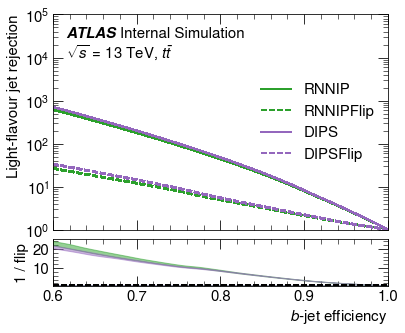

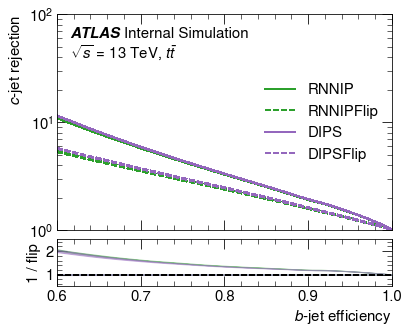

In [51]:
labels=['RNNIP','DIPS']

flipAvgIter(beffs, leffs, labels, labels, ymax=1e5,
            ylabel='Light-flavour jet rejection',
            rlabel='1 / flip', rrange=(0.5,25),
            legLoc='center right',legFontSize=15,
            figDir='figures/',subDir='',tag='l'+tag)

flipAvgIter(beffs, ceffs, labels, labels,ymax=100,
            ylabel='$c$-jet rejection',
            rlabel='1 / flip', rrange=(0.5,2.5),
            legLoc='center right',legFontSize=15,
            figDir='figures/',subDir='',tag='c'+tag)

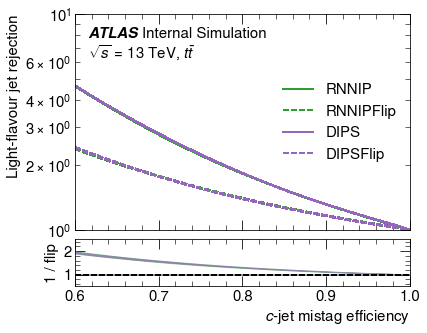

In [52]:
flipAvgIter(ceffs, leffs, labels, labels,ymax=10,
            xlabel='$c$-jet mistag efficiency',ylabel='Light-flavour jet rejection',
            rlabel='1 / flip', rrange=(0.5,2.5),
            legLoc='center right',legFontSize=15,
            figDir='figures/',subDir='',tag='c_mistag_eff_l_rej'+tag)

## Efficiency curves

Ok, so Chris and Rafael were *not* fans of the version of the flipped performance ROC curves that I produced, I'll go ahead and make the "Rachel plot" of the efficiencies as a function of the working point.

I can even make this plot without needing to use the `pchip` function if I *fix* the range for the discriminant.


In [ ]:
    beffs, ceffs, leffs = [], [], []

    for m, name, colors, model_tag, myRange in zip([lstm,dips_bn],['RNNIP','DIPS'], 
                                                   [rnn_colors,dips_colors],['rnn','dips']):
    
        # Get the effs for the nominal configuation
        (l,c,b), d = getEffs(m, X, y, ix, returnDisc=True, figDir=figDir, subDir=subDir, modelDir=modelDir)

        # Get the effs for the flipped configuration
        (l_flip,c_flip,b_flip), d_flip = getEffs(m, X_flip, y, ix, returnDisc=True, figDir=figDir, 
                                                 subDir=subDir, modelDir=modelDir,tag=tag)#,colors=colors)

        leffs += [l, l_flip]
        ceffs += [c, c_flip]
        beffs += [b, b_flip]

        discMax = np.max(np.concatenate((d,d_flip)))
        discMin = np.min(np.concatenate((d,d_flip)))
        myRange=(discMin,discMax) 
        nBins = 100

        cuts = []
        for WP in [85,77,70,60]:

            cut = workingPoint(d[y==2], nBins, myRange, WP=.01*WP)
            cuts.append(cut)

        for yi, flavor, c, s in zip([0,1,2], ['Light-flavour ','$c$-','$b$-'], colors,['-','--','-.']):

            hist_arr  = [d[y == yi], d_flip[y == yi]]
            kargs_arr = [{'histtype':'step','linestyle':s,'linewidth':1.5,
                          'color':c, 'label':f'nominal'}, 
                         {'alpha':0.5,  'color':c, 
                          'label':f'flipped'}]

            rlabel = 'flip / nom'

            dtag = flavor[:-1]+"_disc_"+model_tag+tag
            secondTag = r"$\sqrt{s}$ = 13 TeV, $t\bar{t}$"
            secondTag+=f"\n{name}: {flavor}jets"

            plotRatio(hist_arr, kargs_arr, 
                      xrange=myRange, nBins=nBins,rrange=(0,2),
                      xlabel=xlabel, rlabel=rlabel, title='',
                      tag=dtag, figDir=figDir, subDir=subDir, cuts=cuts,
                      secondTag=secondTag,yscale=200 if yi == 0 else 100)

In [7]:
myRange = (-7.5,15)

x

array([-7.5  , -7.275, -7.05 , -6.825, -6.6  , -6.375, -6.15 , -5.925,
       -5.7  , -5.475, -5.25 , -5.025, -4.8  , -4.575, -4.35 , -4.125,
       -3.9  , -3.675, -3.45 , -3.225, -3.   , -2.775, -2.55 , -2.325,
       -2.1  , -1.875, -1.65 , -1.425, -1.2  , -0.975, -0.75 , -0.525,
       -0.3  , -0.075,  0.15 ,  0.375,  0.6  ,  0.825,  1.05 ,  1.275,
        1.5  ,  1.725,  1.95 ,  2.175,  2.4  ,  2.625,  2.85 ,  3.075,
        3.3  ,  3.525,  3.75 ,  3.975,  4.2  ,  4.425,  4.65 ,  4.875,
        5.1  ,  5.325,  5.55 ,  5.775,  6.   ,  6.225,  6.45 ,  6.675,
        6.9  ,  7.125,  7.35 ,  7.575,  7.8  ,  8.025,  8.25 ,  8.475,
        8.7  ,  8.925,  9.15 ,  9.375,  9.6  ,  9.825, 10.05 , 10.275,
       10.5  , 10.725, 10.95 , 11.175, 11.4  , 11.625, 11.85 , 12.075,
       12.3  , 12.525, 12.75 , 12.975, 13.2  , 13.425, 13.65 , 13.875,
       14.1  , 14.325, 14.55 , 14.775, 15.   ])

In [25]:
def rachelPlot(model='DIPS',nBins=100,nIter=5,save=False,ylim2=None, ratio=False):
    '''
    Goal: Get a plot looking at the efficienciencies for each jet f
    '''
        
    if model == 'RNNIP':
        myRange = (-8,20)
    elif model == 'DIPS':
        myRange = (-10,25)
    else:
        print(f'model {model} not supported - exiting function')
        return
        
    rangeTag = f'_range_{myRange[0]}_{myRange[1]}'
    effFile  = '{}/effIters_{}{}{}.json'.format(modelDir, model, rangeTag, tag)
    colors = ['C0','C1','C2']
    print(effFile)
    
    if save:
        discIter = np.zeros((3,5,nBins))
        flipIter = np.zeros((3,5,nBins))

        cutIter  = np.zeros((4,5))
        WPs = [85,77,70,60]

        # Loop over the iterations    
        for i in range(nIter):

            # Load in the model
            if model == 'RNNIP':
                m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, 
                           dataTag=dataTagTrain+f'_sd0_rev_iter{i}', 
                           nHidden=100,loadModel=True,nClasses=3)
            else:
                m = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
                        modelDir=modelDir, dataTag=dataTagTrain+f'_iter{i}', 
                        batch_norm=True, nClasses=3, loadModel=True)

            # Get the discriminants
            (_, _, _), d = getEffs(m, X, y, ix, figDir=figDir,returnDisc=True,
                                   subDir='', modelDir=modelDir, colors=colors)

            (_, _, _), d_flip = getEffs(m, X_flip, y, ix, figDir=figDir,returnDisc=True,
                              subDir='', modelDir=modelDir,tag=tag,
                              colors=colors)


            # histogramize
            for yi in range(3):

                n, _       = np.histogram(d[y==yi],      nBins, myRange) 
                n_flip, _  = np.histogram(d_flip[y==yi], nBins, myRange) 

                discIter[yi, i] = calculateEff(n)[::-1]
                flipIter[yi, i] = calculateEff(n_flip)[::-1]


            # Get the WPs
            for j, WP in enumerate(WPs):

                cut = workingPoint(d[y==2], nBins, myRange, WP=.01*WP)
                cutIter[j,i] = cut

        
        # Store the efficiencies
        effs_file = open(effFile,'w')
        outputDict = {'discIter':discIter.tolist(),
                      'flipIter':flipIter.tolist(),
                      'cutIter':cutIter.tolist()}
        json.dump(outputDict,effs_file)

        effs_file.close()

    else:
        with open(effFile,'r') as f:
            effDict = json.load(f)

            discIter = np.array(effDict['discIter'])
            flipIter = np.array(effDict['flipIter'])
            cutIter  = np.array(effDict['cutIter'])
        
                     
    # Take the average to get the mean
    disc = np.mean(discIter,axis=1)
    flip = np.mean(flipIter,axis=1)
    
    # Question - should I also try to calculate the standard deviations?
    d_std = np.std(discIter,axis=1)
    f_std = np.std(flipIter,axis=1)
    
    cuts = np.mean(cutIter,axis=1)
    print(cuts, np.std(cutIter,axis=1))
    
    # Make the plot
    fig = plt.figure(0,figsize=(8,5))
#     gs = gridspec.GridSpec(5,1)
#     ax1 = fig.add_subplot(gs[:4,0])
#     ax2 = fig.add_subplot(gs[4:,0],sharex=ax1)
    
    x = np.linspace(*myRange,nBins+1)[:-1]
    
    for i, c, jetTag in zip(range(3), colors, ['Light-flavour ','$c$-','$b$-']):
        plt.plot(x,disc[i],color=c, linestyle='-', label=f'{model}: {jetTag}jets')
        plt.plot(x,flip[i],color=c, linestyle='--',label=f'{model}Flip: {jetTag}jets')

        # Include the ratio nominal / flip in the subpanel
#         ax2.semilogy(x, disc[i]/flip[i], color=c)
    
    # Put the WPs on the plots  
#     if ylim2 is None:
#         ylim2 = ax2.get_ylim()
        
    for cut in cuts:
        
        plt.plot([cut]*2,[0,1],color='grey',linestyle='--')
#         ax2.plot([cut]*2,ylim2,color='grey',linestyle='--')
    
    plt.xlabel('$D_b = \log [ p_b / (f_c p_c + (1- f_c)p_l ) ]$',ha='right',x=1)
    plt.ylabel('1 - Cumulative efficiency',ha='right',y=1)
    #plt.ylabel('1 / flip',ha='right',y=1)
    
    plt.ylim(0,1.3)
#     ax2.set_ylim(ylim2)
    plt.legend(loc='upper right', bbox_to_anchor=(1,.92))
        
    # Add the ATLAS tag
    ax = plt.gca()
    pas.makeATLAStag(ax, fig, first_tag='Internal Simulation', 
                     second_tag=r"$\sqrt{s}$ = 13 TeV, $t\bar{t}$",ymax=.9)

#     fig.subplots_adjust(hspace=0.5)
    
    # Save the figure
    plt.savefig(f'figures/varyEff_{model}.pdf',bbox_inches='tight')
    
    plt.show()

../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/effIters_DIPS_range_-10_25_flip.json
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/DIPS_phi_100_100_128_F_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_iter0_weights.h5
Loading previously trained DIPS weight file
../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/effs_DIPS_phi_100_100_128_F_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_iter0.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/effs_DIPS_phi_100_100_128_F_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nspl

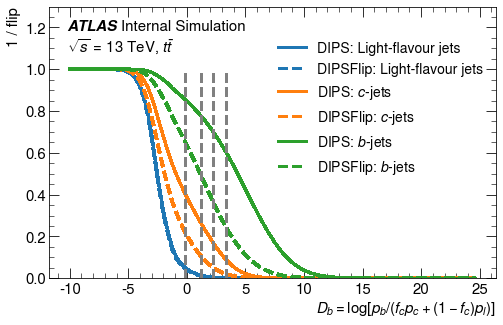

In [27]:
rachelPlot(save=True)

In [ ]:
rachelPlot('RNNIP',save=True,ylim2=(1,100))

../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/effIters_RNNIP_range_-8_20_flip.json
Initialize method from myModel()
Loading previously trained LSTM
../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_iter0.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_BTagging201903_ttbar_pt_1000_d0_1_z0_1.5/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_iter0_flip.json
Load in the previously saved efficiency file
i_eff = 70, teff = 0.8468993509489979
Cut on discriminant at 0.120000000000001
i_eff = 65, teff = 0.7660725371084054
Cut on discriminant at 1.5200000000000014
i_eff = 62, teff = 0.70438